# Sketching AutoEncoder (masked)

This is a prototype "sketching" AutoEncoder with masking to achieve variable length reconstruction. The encoder maps an input raster image into an $n\times2\times2$ vector and a $n$ soft mask vector (elements ~1 or ~0). 

The decoder is an a differentiable line rasteriser which interprets the encoder output as $n$ vectors of $[[x0,y0],[x1,y1]]$ representing the starting and ending coordinates of a line segment and the mask value as a "colour" which controls the visibility. Lines are composed using `soft-or` so a coloured line always has precidence. The decoder doesn't have any learnable parameters and is entirely deterministic.

In [1]:
import torch
import torch.nn as nn
try:
    from dsketch.raster.disttrans import line_edt2
    from dsketch.raster.raster import exp
    from dsketch.raster.composite import softor
except:
    !pip install git+https://github.com/jonhare/DifferentiableSketching.git
    from dsketch.raster.disttrans import line_edt2
    from dsketch.raster.raster import exp
    from dsketch.raster.composite import softor

    
class MaskedAE(nn.Module):
  def __init__(self, nlines=30, hidden=64, sz=28):
    super(MaskedAE, self).__init__()

    # build the coordinate grid:
    r = torch.linspace(-1, 1, sz)
    c = torch.linspace(-1, 1, sz)
    grid = torch.meshgrid(r, c)
    grid = torch.stack(grid, dim=2)
    self.register_buffer("grid", grid)

    # encoder
    self.enc_shared = nn.Sequential(
        nn.Linear(sz**2, hidden),
        nn.ReLU())
    self.enc_pos = nn.Sequential(
        nn.Linear(hidden, nlines*4),
        nn.Tanh())
    self.enc_mas = nn.Sequential(
        nn.Linear(hidden, nlines),
        nn.Sigmoid())

  def forward(self, inp, sigma=7e-3):
    # the encoding process will flatten the input and
    # push it through the encoder network
    bs = inp.shape[0]
    x = inp.view(bs, -1) # [batch,28,28] -> [batch,28*28]
    z = self.enc_shared(x) 
    
    pos = self.enc_pos(z) # -> [batch, nlines*4]
    pos = pos.view(bs, -1, 2, 2) # -> [batch, nlines, 2, 2]
    
    mas = self.enc_mas(z) # -> [batch, nlines]

    # Rasterisation steps
    rasters = exp(line_edt2(pos, self.grid), sigma) # -> [batch, nlines, 28, 28]

    mas = mas.view(*mas.shape, 1, 1) # unsqueeze and extra two dims at the end
    rasters = rasters * mas # mask
    
    return softor(rasters), pos, mas

We'll do a simple test on MNIST and try and train the AE to be able to reconstruct digit images (and of course at the same time perform image vectorisation/autotracing). Hyperparameters are pretty arbitrary (defaults for Adam; 256 batch size) and the line width is fixed to a value that works well for MNIST.

In [2]:
import matplotlib.pyplot as plt
from torchvision.datasets.mnist import MNIST
from torchvision import transforms
import torchvision

batch_size = 1024

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(28, 28))
    ])
trainset = torchvision.datasets.MNIST('/tmp', train=True, transform=transform, download=True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
testset = torchvision.datasets.MNIST('/tmp', train=False, transform=transform, download=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = MaskedAE().to(device)

opt = torch.optim.Adam(model.parameters())

for epoch in range(50):
    for images, classes in trainloader:
        images = images.to(device)
        opt.zero_grad()
        out, _, _ = model(images)
        loss = nn.functional.mse_loss(out, images)
        loss.backward()
        opt.step()

    print(loss)

tensor(0.0421, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0331, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0255, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0228, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0200, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0182, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0176, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0166, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0156, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0155, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0149, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0143, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0135, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0133, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0133, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0133, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0122, device='cuda:0', grad_fn=<MseLossBackward

Finally here's a visualisation of a set of test inputs and their rendered reconstructions:

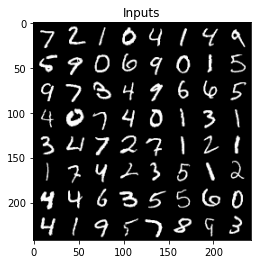

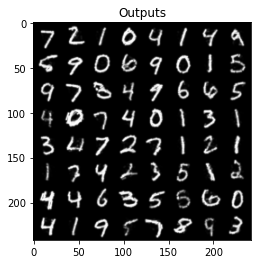

In [3]:
batch = iter(testloader).next()[0][0:64]
out, pos, mas = model(batch.to(device))

plt.figure()
inputs = torchvision.utils.make_grid(batch.unsqueeze(1))
plt.title("Inputs")
plt.imshow(inputs.permute(1,2,0))

plt.figure()
outputs = torchvision.utils.make_grid(out.detach().cpu().unsqueeze(1))
plt.title("Outputs")
plt.imshow(outputs.permute(1,2,0))